<a href="https://colab.research.google.com/github/jackliu333/gradient_editing/blob/main/Gradient_editing_on_the_fly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(8)

# The overall model training workflow
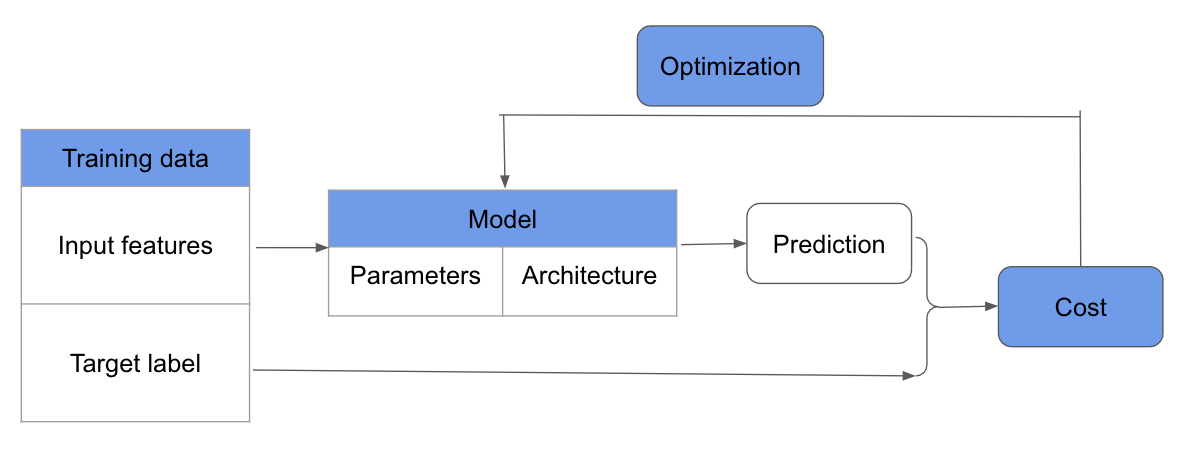

# Data

In [2]:
# download MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [3]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [5]:
train_data.targets.size()

torch.Size([60000])

Text(0.5, 1.0, 'Digit: 5')

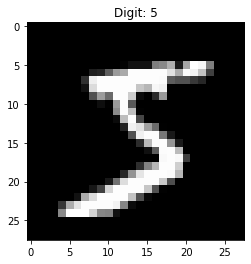

In [6]:
plt.imshow(train_data.data[0], cmap="gray")
plt.title("Digit: {}".format(train_data.targets[0]))

In [7]:
# preparing data for training with DataLoaders
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, # data source to be loaded
                                          batch_size=100, #  the number of training samples used in one iteration
                                          shuffle=True), # samples are shuffled and loaded in batches
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True)}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f0b05492410>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f0b05492090>}

In [8]:
# extract one batch of data
X, y = next(iter(loaders['train']))
print(X.shape)
print(y.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


# Model

In [9]:
import torch.nn as nn
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [10]:
model = simpleNN()
print(model)

simpleNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)


In [11]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 10]           1,010
              ReLU-4                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [12]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   78400    |
|  fc1.bias  |    100     |
| fc2.weight |    1000    |
|  fc2.bias  |     10     |
+------------+------------+
Total Trainable Params: 79510


79510

In [13]:
params = {}
for name, param in model.named_parameters():
    params[name] = param

In [14]:
params.keys()

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [15]:
params['fc2.bias']

Parameter containing:
tensor([-0.0664, -0.0503, -0.0958,  0.0065, -0.0272,  0.0990, -0.0904,  0.0140,
         0.0204, -0.0831], requires_grad=True)

# Cost

In [16]:
# use the default CEL function from the nn module
cost_func = nn.CrossEntropyLoss()  
# the first class starts with index 0
tmp_y = torch.tensor([0])
pred_good = torch.tensor([[2, 0.8, 0.5]])
loss_good = cost_func(pred_good, tmp_y)
loss_good

tensor(0.4216)

In [17]:
pred_bad = torch.tensor([[1, 6, 0.2]])
loss_bad = cost_func(pred_bad, tmp_y)
loss_bad

tensor(5.0097)

# Optimization - gradient descent
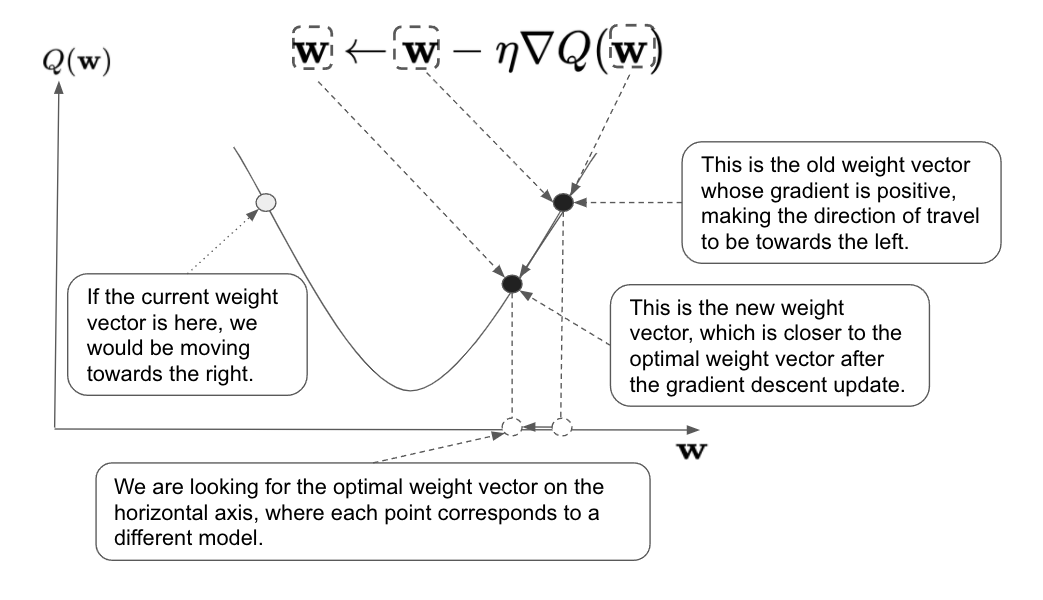

In [18]:
# Define the procedure
from torch import optim
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr = lr)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

# Training - one iteration

In [19]:
print("initial bias value")
print(params['fc2.bias'].data.numpy())
# Call the forward method (under the hood) to produce prediction
pred = model(X)               
# Calculate the current cost
cost = cost_func(pred, y)
print("initial bias gradient")
print(params['fc2.bias'].grad)
# Clear existing gradients
optimizer.zero_grad()           
# Perform backpropagation and compute gradients 
cost.backward()    
print("updated bias gradient:")
print(params['fc2.bias'].grad.data.numpy())
# Update weights using SGD
optimizer.step()       
print("updated bias value:")
print(params['fc2.bias'].data.numpy())

initial bias value
[-0.06640004 -0.05030024 -0.09580158  0.00651282 -0.02724841  0.09897009
 -0.09038023  0.01400825  0.02041563 -0.08312523]
initial bias gradient
None
updated bias gradient:
[ 0.00192186  0.03469279  0.00285702 -0.00632174 -0.01289486  0.07373834
  0.         -0.01973931 -0.00338887  0.00097357]
updated bias value:
[-0.06641926 -0.05064717 -0.09583016  0.00657604 -0.02711946  0.09823271
 -0.09038023  0.01420564  0.02044952 -0.08313497]


# Gradient clipping

In [20]:
print("bias gradient before gradient clipping")
print(params['fc2.bias'].grad.data.numpy())

# perform in-place gradient clipping
torch.nn.utils.clip_grad_value_(model.parameters(), 0.05)

print("bias gradient after gradient clipping")
print(params['fc2.bias'].grad.data.numpy())

bias gradient before gradient clipping
[ 0.00192186  0.03469279  0.00285702 -0.00632174 -0.01289486  0.07373834
  0.         -0.01973931 -0.00338887  0.00097357]
bias gradient after gradient clipping
[ 0.00192186  0.03469279  0.00285702 -0.00632174 -0.01289486  0.05
  0.         -0.01973931 -0.00338887  0.00097357]


# Gradient masking



In [21]:
print("bias gradient before gradient masking")
print(params['fc2.bias'].grad.data.numpy())

# disable gradient update for some parameters
grad_mask = torch.rand(params['fc2.bias'].grad.size()) < 0.5
for name, param in model.named_parameters():
    if name == "fc2.bias":
        param.grad.mul_(grad_mask)

print("bias gradient after gradient masking")
print(params['fc2.bias'].grad.data.numpy())

bias gradient before gradient masking
[ 0.00192186  0.03469279  0.00285702 -0.00632174 -0.01289486  0.05
  0.         -0.01973931 -0.00338887  0.00097357]
bias gradient after gradient masking
[ 0.00192186  0.03469279  0.         -0.         -0.01289486  0.05
  0.         -0.         -0.00338887  0.00097357]


# Gradient perturbation

In [22]:
print("bias gradient before gradient perturbation")
print(params['fc2.bias'].grad.data.numpy())

# disable gradient update for some parameters
grad_mask = torch.rand(params['fc2.bias'].grad.size()) < 0.5
for name, param in model.named_parameters():
    if name == "fc2.bias":
        tmp_noise = torch.normal(0, 0.1, size=param.grad.shape)
        param.grad.add_(tmp_noise)

print("bias gradient after gradient perturbation")
print(params['fc2.bias'].grad.data.numpy())

bias gradient before gradient perturbation
[ 0.00192186  0.03469279  0.         -0.         -0.01289486  0.05
  0.         -0.         -0.00338887  0.00097357]
bias gradient after gradient perturbation
[ 0.02359298  0.23755082 -0.08900809  0.11972915  0.05038314  0.11356081
  0.1244363  -0.13254979 -0.21102257  0.02179109]


# Gradient replacement

In [23]:
print("bias gradient before gradient perturbation")
print(params['fc2.bias'].grad.data.numpy())

# disable gradient update for some parameters
grad_mask = torch.rand(params['fc2.bias'].grad.size()) < 0.5
for name, param in model.named_parameters():
    if name == "fc2.bias":
        tmp_noise = torch.normal(0, 0.1, size=param.grad.shape)
        param.grad = tmp_noise

print("bias gradient after gradient perturbation")
print(params['fc2.bias'].grad.data.numpy())

bias gradient before gradient perturbation
[ 0.02359298  0.23755082 -0.08900809  0.11972915  0.05038314  0.11356081
  0.1244363  -0.13254979 -0.21102257  0.02179109]
bias gradient after gradient perturbation
[ 0.16691972  0.01774203  0.05624134 -0.04956153  0.15166555 -0.06935373
  0.0514021  -0.01009593  0.02139831  0.09265094]
